# TODO

* Simulations:
    * gempy only Monte Carlo forward simulation for comparison
    * noddy Monte Carlo forward simulation
        * extract likelihoods
    * gempy with noddy-extracted likelihoods
* posterior analysis
    * IE
    
* clean up of initial data extraction for future use
    * flexible functions
    * vectorize

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#plt.style.use('bmh')
plt.style.use("seaborn-colorblind")
import sys
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/pynoddy/")

import pynoddy.history
import pynoddy.output
import pynoddy.experiment

import pymc

import sys, os
#sys.path.append("C:/Users/lebobcrash/Documents/GitHub/Theano/")

import theano.tensor as T
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/pygeomod/pygeomod")
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/GeMpy/GeMpy")
import GeoMig
import importlib
#import geogrid
reload(GeoMig)
import importlib
#importlib.reload(GeoMig)
import numpy as np
import pandas as pn
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from skimage import measure

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib inline
%matplotlib notebook

import pandas as pd

### Define Noddy Priors

In [2]:
prior_dict = {
    "stratigraphy_rotation": {
        "mean": 0.,
        "stdev": 5.
    },
    "layer2_height": {
        "mean": 500.,
        "stdev": 50.
    },
    "layer3_height": {
        "mean": 300.,
        "stdev": 30.
    },
    "unconformity_height": {
        "mean": 650.,
        "stdev": 65.
    },
    "unconformity_rotation": {
        "mean": -10.,
        "stdev": 5.
    },
    "fold_amplitude": {
        "mean": 350.,
        "stdev": 25.
    },
    "fold_wavelength": {
        "mean": 2500.,
        "stdev": 140.
    }
    
}

##### Parameters

In [3]:
cs = 5
initial_history = "init.his"

##### Create Noddy History File

<IPython.core.display.Javascript object>


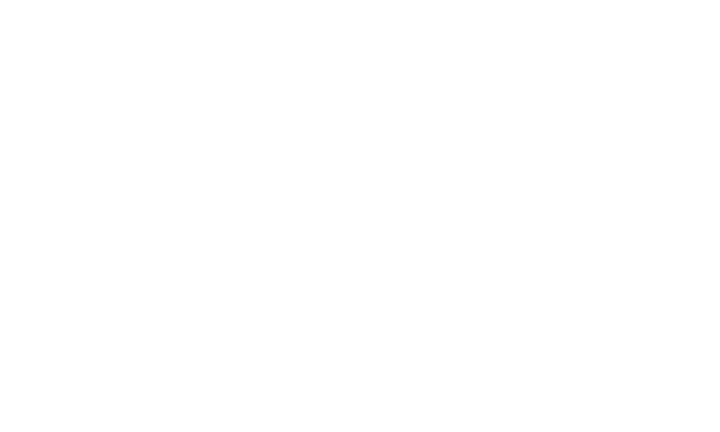

<IPython.core.display.Javascript object>


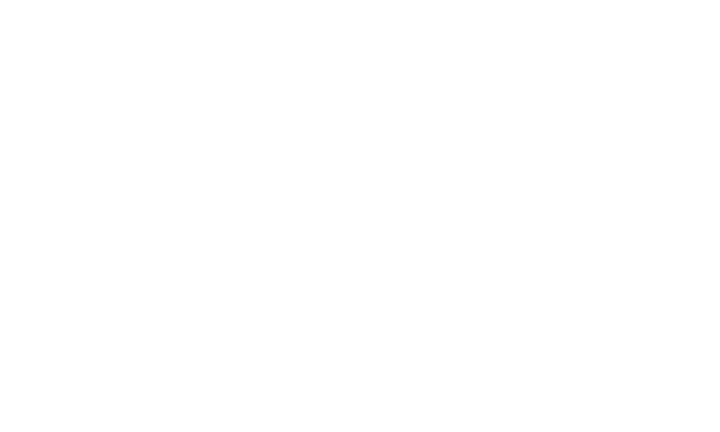

In [40]:
nm = pynoddy.history.NoddyHistory()
nm.set_extent(2000.,20.,1000.)
# set model origin x,y,z
nm.set_origin(0.,0.,1000.)
# set model cube size
nm.change_cube_size(cs)

strati_options = {'num_layers' : 4,
                  'layer_names' : ['4','3','2','1'],
                  'layer_thickness' : [0,300,220,100]} # is this actually the position/height of the layer boundary?!
nm.add_event('stratigraphy', strati_options )

tilt_options = {
    "name": "tilt1",
    "pos": (700,0,1000),
    "rotation": prior_dict["stratigraphy_rotation"]["mean"],
    "plunge_direction": 0.,
    "plunge": 0.
}

#nm.add_event("tilt", tilt_options)

fold_options = {
    "name": "fold1",
    "pos": (300,0,0),
    "amplitude": prior_dict["fold_amplitude"]["mean"],
    "wavelength": prior_dict["fold_wavelength"]["mean"],
    "dip": 90.,
    "dip_dir": 90.
}

nm.add_event("fold", fold_options)

unconf_options = {
    "name": "unfonf1",
    "pos": (0,0,prior_dict["unconformity_height"]["mean"]),
    "rotation": 0.,
    "dip_direction": 90.,
    "dip": prior_dict["unconformity_rotation"]["mean"],
    "num_layers": 1,
    "layer_names": ["a"],
    "layer_thickness": [700]
}

#nm.add_event("unconformity", unconf_options)

nm.write_history(initial_history)
ex = pynoddy.experiment.Experiment(initial_history)
ex.plot_section("y")

#### Extract X Wells for use as gempy Prior Means

one time only, this needs cleanup: functions and verctorized when possible, also more flexible

In [12]:
x_wells = [40,220,340]
y_wells = 0

In [13]:
wells = np.array([ex.get_drillhole_data(x_wells[0]*cs,y_wells*cs),
                  ex.get_drillhole_data(x_wells[1]*cs,y_wells*cs),
                  ex.get_drillhole_data(x_wells[2]*cs,y_wells*cs)])
print np.shape(wells)



(3L, 1000L)


In [14]:
foliation_col_names = ["X", "Y", "Z", "azimuth", "dip", "polarity", "formation"]
foliations = pd.DataFrame(columns=foliation_col_names)
interfaces_col_names = ["X", "Y", "Z", "formation"]
interfaces = pd.DataFrame(columns=interfaces_col_names)

loc = 0
for i,well in enumerate(wells):
    for layer in np.unique(well):
        loc += 1
        z = np.where(well==layer)[0][0]
        y = y_wells
        x = x_wells[i]
        if z == 0. or z == 0:
            pass
        else:
            interfaces.loc[loc] = [x,y,z/cs,"Layer"+str(int(layer))]

for i in range(len(interfaces)-3):
    x = (interfaces.iloc[i]["X"] + interfaces.iloc[i+3]["X"])/2
    y = 0.
    z = (interfaces.iloc[i]["Z"] + interfaces.iloc[i+3]["Z"])/2
    dz = (interfaces.iloc[i]["Z"] - interfaces.iloc[i+3]["Z"])
    dx = (interfaces.iloc[i]["X"] - interfaces.iloc[i+3]["X"])
    tan = float(dz)/float(dx)
    dip = np.rad2deg(np.arctan(tan))
    az = 90.
    pol = 1.
    #print (x,y,z,dip)
    foliations.loc[i] = [x,y,z,az,-1*dip,pol,interfaces.iloc[i]["formation"]]

In [29]:
import pickle

In [30]:
pickle.dump( interfaces, open( "gempy_interfaces.p", "wb" ) )


In [15]:
interfaces

,X,Y,Z,formation
1,40.0,0.0,106.0,Layer1
2,40.0,0.0,86.0,Layer2
3,40.0,0.0,42.0,Layer3
5,220.0,0.0,186.0,Layer1
6,220.0,0.0,166.0,Layer2
7,220.0,0.0,122.0,Layer3
9,340.0,0.0,98.0,Layer1
10,340.0,0.0,78.0,Layer2
11,340.0,0.0,34.0,Layer3


In [16]:
foliations

,X,Y,Z,azimuth,dip,polarity,formation
0,130.0,0.0,146.0,90.0,-23.962489,1.0,Layer1
1,130.0,0.0,126.0,90.0,-23.962489,1.0,Layer2
2,130.0,0.0,82.0,90.0,-23.962489,1.0,Layer3
3,280.0,0.0,142.0,90.0,36.253838,1.0,Layer1
4,280.0,0.0,122.0,90.0,36.253838,1.0,Layer2
5,280.0,0.0,78.0,90.0,36.253838,1.0,Layer3


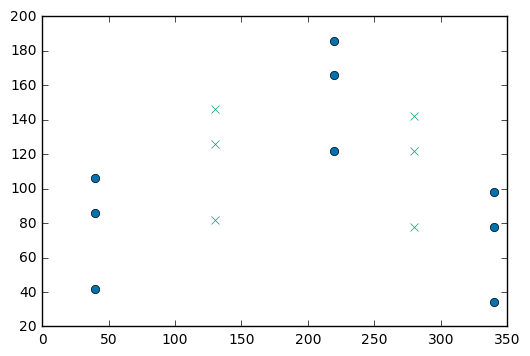

In [36]:
%matplotlib inline
plt.plot(interfaces["X"],interfaces["Z"],"o")
plt.plot(foliations["X"],foliations["Z"],"x")

##### Initiate gempy Model

In [18]:
GM = GeoMig.Interpolator(0,400,
                         0,10,
                         0,200,
                         u_grade=3)

# set grid resolution
GM.set_resolutions(400,4,200)
GM.create_regular_grid_3D()

# compile
GM.theano_compilation_3D()

C:\Users\lebobcrash\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


(0, 200)

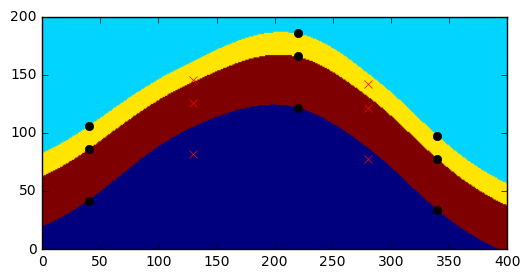

In [20]:
GM.load_data_pd("foliations", foliations)
GM.load_data_pd("interfaces", interfaces)

initial = []
for layer in GM.formations:
    initial.append(layer)

GM.set_series({"Initial": tuple(initial)})

#GM.compute_potential_field("Initial", verbose = 0)
#GM.compute_potential_field("Unconformity", verbose = 0)


GM.block.set_value(np.zeros_like(GM.grid[:,0]))

# Compute the block
GM.compute_block_model([0], verbose = 0)
plot_block =  GM.block.get_value().reshape(400,4,200)

plt.imshow(plot_block[:,2,:].T, origin="lower")
plt.plot(GM.Foliations["X"],GM.Foliations["Z"],"rx")
plt.plot(GM.Interfaces["X"],GM.Interfaces["Z"],"ko")
plt.xlim(0,400)
plt.ylim(0,200)

#### Creating the gempy Priors

In [21]:
priors = [pymc.Normal(str(int(value[0]))+"_"+value[-1], value[2], 1./np.square(value[2]/5.)) for value in interfaces.values]

In [27]:
np.save("gempy_prior_values", interfaces.values)

In [22]:
priors

[<pymc.distributions.Normal '40_Layer1' at 0x000000001813A0B8>,
 <pymc.distributions.Normal '40_Layer2' at 0x000000001845D0B8>,
 <pymc.distributions.Normal '40_Layer3' at 0x000000001845D160>,
 <pymc.distributions.Normal '220_Layer1' at 0x000000001813A128>,
 <pymc.distributions.Normal '220_Layer2' at 0x000000001813A160>,
 <pymc.distributions.Normal '220_Layer3' at 0x000000001813A198>,
 <pymc.distributions.Normal '340_Layer1' at 0x000000001813A1D0>,
 <pymc.distributions.Normal '340_Layer2' at 0x000000001813A208>,
 <pymc.distributions.Normal '340_Layer3' at 0x000000001813A240>]

## PYMC gempy

In [266]:
@pymc.deterministic
def gempy_model(value=0, priors=priors, interf=interfaces, verbose=0):
    
    # set Z values in interface dataframe to prior values and load into gempy model object
    interf["Z"] = priors
    GM.load_data_pd("interfaces", interf)
    
    if verbose == 1:
        print GM.Interfaces
    
    # interpolate dip angles from wells and create foliation dataframe
    foliation_col_names = ["X", "Y", "Z", "azimuth", "dip", "polarity", "formation"]
    fol = pd.DataFrame(columns=foliation_col_names)
    for i in range(len(interf)-3):
        x = (interf.iloc[i]["X"] + interf.iloc[i+3]["X"])/2
        y = 0.
        z = (interf.iloc[i]["Z"] + interf.iloc[i+3]["Z"])/2
        dz = (interf.iloc[i]["Z"] - interf.iloc[i+3]["Z"])
        dx = (interf.iloc[i]["X"] - interf.iloc[i+3]["X"])
        tan = float(dz)/float(dx)
        dip = np.rad2deg(np.arctan(tan))
        az = 90.
        pol = 1.
        fol.loc[i] = [x,y,z,az,-1*dip,pol,interf.iloc[i]["formation"]]
    GM.load_data_pd("foliations", fol)
    
    if verbose == 1:
        print GM.Foliations
    
    # load layers into series
    initial = []
    for layer in GM.formations:
        initial.append(layer)
    GM.set_series({"Initial": tuple(initial)})
    
    # gempy magic calculation
    GM.block.set_value(np.zeros_like(GM.grid[:,0]))
    GM.compute_block_model([0], verbose = 0)
    plot_block =  GM.block.get_value().reshape(200,4,100)
    
    # return gempy block model
    return plot_block[:,2,:]

params = [priors[i] for i in range(len(priors))]
params.append(gempy_model)
model = pymc.Model(params)

In [268]:
RUN = pymc.MCMC(model)
RUN.sample(iter=30)

 [-----------------103%------------------] 31 of 30 complete in 39.7 sec

In [222]:
def plot_posterior_sections(x):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    
    ax.set_title("gempy")
    ax.imshow(gempy_model_posterior[x].T, origin="lower left", interpolation="nearest")
    
    ax.set_xlim(0,200)
    ax.set_ylim(0,100)

In [271]:
gempy_model_posterior = RUN.trace("gempy_model")[:]

# PYMC Noddy

In [5]:
layer2_height = pymc.Normal("layer2_height", prior_dict["layer2_height"]["mean"], 1./np.square(prior_dict["layer2_height"]["stdev"]))
layer3_height = pymc.Normal("layer3_height", prior_dict["layer3_height"]["mean"], 1./np.square(prior_dict["layer3_height"]["stdev"]))
fold_amplitude = pymc.Normal("fold_amplitude", prior_dict["fold_amplitude"]["mean"], 1./np.square(prior_dict["fold_amplitude"]["stdev"]))
fold_wavelength = pymc.Normal("fold_wavelength", prior_dict["fold_wavelength"]["mean"], 1./np.square(prior_dict["fold_wavelength"]["stdev"]))

In [6]:
# create initial pynoddy experiment object
ex_mcmc = pynoddy.experiment.Experiment(initial_history)

# NODDY MODEL CALCULATION
@pymc.deterministic
def pynoddy_model(value=0,
                 #stratigraphy_rotation=stratigraphy_rotation, 
                 fold_amplitude=fold_amplitude, 
                 fold_wavelength=fold_wavelength, 
                 layer2_height=layer2_height, 
                 layer3_height=layer3_height, 
                 #unconformity_height=unconformity_height,
                 #unconformity_rotation=unconformity_rotation,
                 ex=ex_mcmc, cs=cs, verbose=0):
    """
    Whoop-dee Whoop.
    """
    # modify event 1: stratigraphy
    #for unit in ex.events[1].layers:
    #    if unit.properties["Unit Name"] == 2.0:
    #        unit.properties["Height"] = layer2_height
    #    elif unit.properties["Unit Name"] == 3.0:
    #        unit.properties["Height"] = layer3_height
    
    ex.events[1].layers[1].properties["Height"] = layer3_height
    ex.events[1].layers[2].properties["Height"] = layer2_height
    
    # modify event 3: fold
    ex.events[2].properties["Amplitude"] = fold_amplitude
    ex.events[2].properties["Wavelength"] = fold_wavelength

    
    # write history of modified experiment
    #ex.write_history("pymc_history.his")
    # compute model with files necessary for topology analysis
    #pynoddy.compute_model("pymc_history.his", "pymc_noddy_output", sim_type="TOPOLOGY")
    #model = pynoddy.output.NoddyOutput("pymc_noddy_output")
    
    if verbose == 1:
        ex.plot_section("y")
        
    section = ex.get_section("y")
    # return model section
    return section.block[:,0,:]

In [7]:
noddy_params = [layer2_height,layer3_height,fold_amplitude,fold_wavelength,pynoddy_model]
noddy_pymc_model = pymc.Model(noddy_params)

In [9]:
noddy_RUN = pymc.MCMC(noddy_pymc_model)
noddy_RUN.sample(iter=10000)

 [-----------------100%-----------------] 10001 of 10000 complete in 16671.9 sec

In [12]:
save_parameters("pynoddy_parameters", noddy_params)

In [8]:
def save_posteriors(params, pymc_run):
    for entity in params:
        np.save(str(entity)+"_posterior", pymc_run.trace(entity)[:])
        print str(entity)+"_posterior saved successfully."

In [ ]:
class PosteriorSectionAnalysis:
    def __init__(self, posterior_array):
        self.sections = posterior_array
        self.layers = np.unique(self.sections)
    
    def extract_layer_heights(self, x, layer):
        """Extracts z-positions of a lower layer interface at position x."""
        array = np.array([])
        for i in range(len(self.sections[:,0,0])):
            if layer in np.unique(self.sections[i,x,:]):
                array = np.append(array,np.where(self.sections[i,x,:]==layer)[0][0])
            else:
                pass
        return array
    
    def kde(self, data):
        """Gaussian KDE estimation using scipy.stats.kde. Input: histogram data (list or array)."""
        from scipy.stats.kde import gaussian_kde
        return gaussian_kde(np.array(data))
    
def like(kde, value):
    """Returns the log probability of a value from the input kde. Can be directly used as a pymc likelihood function."""
    return np.log(kde.evaluate(value))[0]

In [11]:
def save_parameters(name, parameters):
    file = open(name+".txt", "w")
    
    for entry in parameters:
        file.write(str(entry)+"\n")
    file.close()

In [14]:
import Posterior2 as ps
reload(ps)

<module 'Posterior2' from 'Posterior2\__init__.pyc'>

In [15]:
test = ps.Posteriors("pynoddy_parameters", "pynoddy")

In [17]:
%matplotlib inline

In [35]:
test.browse_sections()

NameError: name 'test' is not defined

In [19]:
test.compute_entropy()

Per-voxel IE has been saved into self.entropy_voxels and the total IE into self.entropy_total.


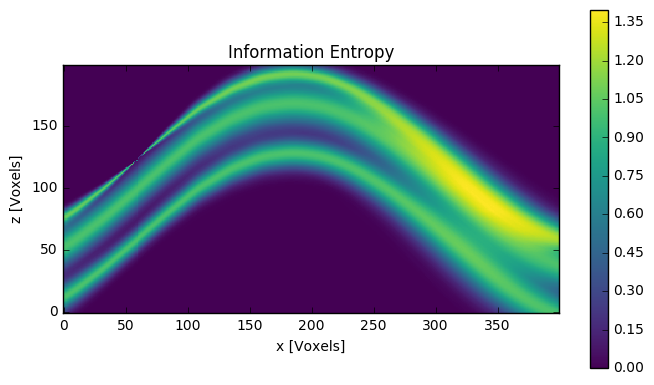

In [20]:
test.plot_entropy()

In [26]:
np.save("pynoddy_entropy_voxels",test.entropy_voxels)
np.save("pynoddy_entropy_total",test.entropy_total)

In [776]:
reload(ps)

<module 'Posterior2' from 'Posterior2\__init__.py'>

In [444]:
like(a,85)

-2.5481560318814815

### Define Likelihood Functions

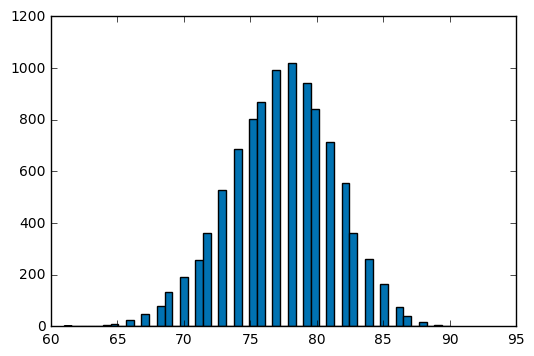

In [42]:
plt.hist(test.extract_layer_height(1)["1"],bins=50);

In [30]:
test.extract_layer_thickness(1)

{'1': array([ 119.,  124.,  121., ...,  126.,  123.,  123.]),
 '2': array([ 17.,  22.,  22., ...,  21.,  30.,   8.]),
 '3': array([ 42.,  45.,  51., ...,  41.,  29.,  58.]),
 '4': array([ 22.,   9.,   6., ...,  12.,  18.,  11.])}